IMPORTING AND LOADING DATA

In [34]:
# utilities
import re
import numpy as np
import pandas as pd
import sqlite3 as sq3
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
!pip install -q wordcloud
import wordcloud
!pip install textblob
!pip install textsearch
!pip install contractions
!pip install afinn
import textblob
import nltk
nltk.download('vader_lexicon')
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 
from nltk.tokenize import word_tokenize
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from termcolor import colored

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [35]:
path = '/content/drive/MyDrive/Colab Notebooks/Sentiment.db'
con = sq3.Connection(path)
query = """
SELECT *
FROM airline;
"""
dataset = pd.read_sql(query, con)
dataset.columns = ['tweet_id','airline_sentiment','airline_sentiment_confidence','negativereason','negativereason_confidence','airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweetcount', 'text', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone']
dataset = dataset.iloc[1:]
dataset.index = range(len(dataset))
dataset.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweetcount,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0,None,None,Virgin America,None,cairdin,None,0,@VirginAmerica What @dhepburn said.,None,2015-02-24 11:35:52 -0800,None,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,None,0.0,Virgin America,None,jnardino,None,0,@VirginAmerica plus you've added commercials t...,None,2015-02-24 11:15:59 -0800,None,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,None,None,Virgin America,None,yvonnalynn,None,0,@VirginAmerica I didn't today... Must mean I n...,None,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0,Bad Flight,0.7033,Virgin America,None,jnardino,None,0,@VirginAmerica it's really aggressive to blast...,None,2015-02-24 11:15:36 -0800,None,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0,Can't Tell,1.0,Virgin America,None,jnardino,None,0,@VirginAmerica and it's a really big bad thing...,None,2015-02-24 11:14:45 -0800,None,Pacific Time (US & Canada)


EXPLORATORY DATA ANALYSIS

In [36]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   tweet_id                      14640 non-null  object
 1   airline_sentiment             14640 non-null  object
 2   airline_sentiment_confidence  14640 non-null  object
 3   negativereason                9178 non-null   object
 4   negativereason_confidence     10522 non-null  object
 5   airline                       14640 non-null  object
 6   airline_sentiment_gold        40 non-null     object
 7   name                          14640 non-null  object
 8   negativereason_gold           32 non-null     object
 9   retweetcount                  14640 non-null  object
 10  text                          14640 non-null  object
 11  tweet_coord                   1019 non-null   object
 12  tweet_created                 14640 non-null  object
 13  tweet_location  

Three types of sentiments possible:  ['neutral' 'positive' 'negative']


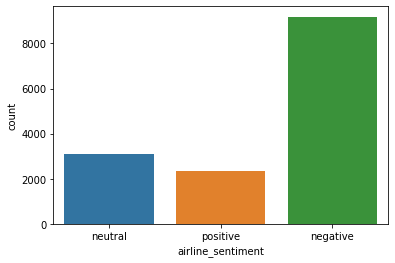

In [37]:
print('Three types of sentiments possible: ', dataset['airline_sentiment'].unique())
sentiment_distribution = sns.countplot(x = "airline_sentiment", data = dataset)

The number of tweets concerning each airline: 


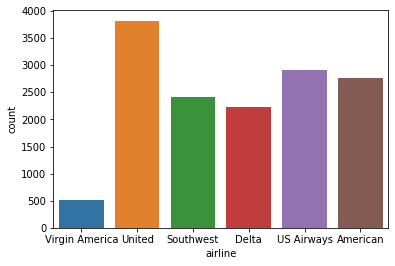

In [38]:
print("The number of tweets concerning each airline: ")
airline_tweet_distribution = sns.countplot(x = "airline", data = dataset)

In [39]:
print('The main reasons for a negative tweet: ', dataset['negativereason'].unique())

The main reasons for a negative tweet:  [None 'Bad Flight' "Can't Tell" 'Late Flight' 'Customer Service Issue'
 'Flight Booking Problems' 'Lost Luggage' 'Flight Attendant Complaints'
 'Cancelled Flight' 'Damaged Luggage' 'longlines']


The count for each negative reason that led to a tweet:  Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64


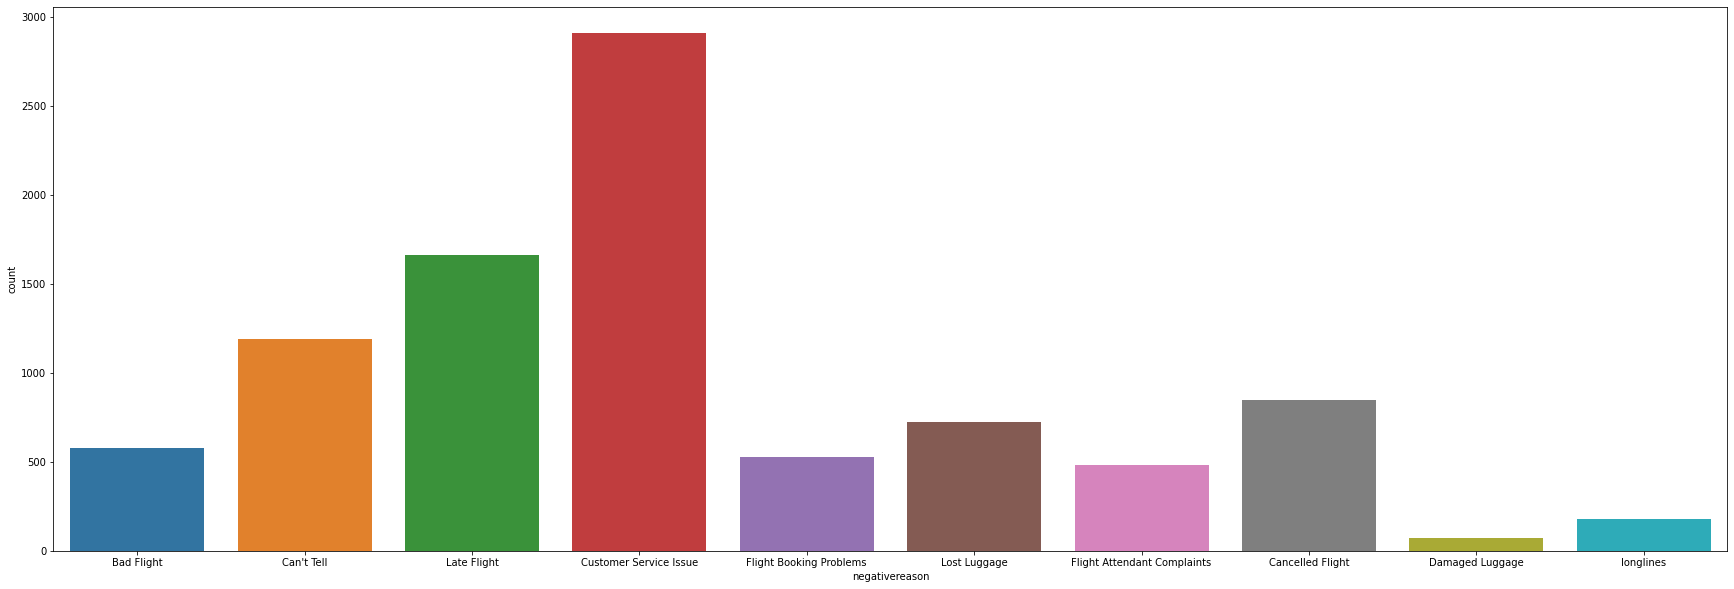

In [40]:
print('The count for each negative reason that led to a tweet: ', dataset.negativereason.value_counts())
plt.figure(figsize = (30, 10))
sns.countplot(x = 'negativereason', data = dataset)
plt.show()

DATA PREPROCESSING

In [41]:
dataset['airline_sentiment'].replace(('neutral', 'positive', 'negative'), (0, 1, -1), inplace=True)
dataset['airline_sentiment'].value_counts()
#dataset['text'].head()

-1    9178
 0    3099
 1    2363
Name: airline_sentiment, dtype: int64

In [42]:
data_text = dataset['text']
data_text.head()

0                  @VirginAmerica What @dhepburn said.
1    @VirginAmerica plus you've added commercials t...
2    @VirginAmerica I didn't today... Must mean I n...
3    @VirginAmerica it's really aggressive to blast...
4    @VirginAmerica and it's a really big bad thing...
Name: text, dtype: object

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


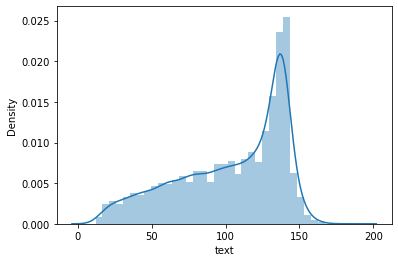

In [43]:
sns.distplot(dataset.text.str.len())
plt.show()

In [44]:
dataset.text.str.len().describe()

count    14640.000000
mean       103.822063
std         36.277339
min         12.000000
25%         77.000000
50%        114.000000
75%        136.000000
max        186.000000
Name: text, dtype: float64

In [45]:
STOPWORDS=stopwords.words('english')
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
data_text = data_text.apply(lambda text: cleaning_stopwords(text))
data_text.head()

0                  @VirginAmerica What @dhepburn said.
1    @VirginAmerica plus added commercials experien...
2    @VirginAmerica I today... Must mean I need tak...
3    @VirginAmerica really aggressive blast obnoxio...
4                  @VirginAmerica really big bad thing
Name: text, dtype: object

In [46]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
data_text = data_text.apply(lambda x: cleaning_punctuations(x))
data_text.head()

0                     VirginAmerica What dhepburn said
1    VirginAmerica plus added commercials experienc...
2    VirginAmerica I today Must mean I need take an...
3    VirginAmerica really aggressive blast obnoxiou...
4                   VirginAmerica really big bad thing
Name: text, dtype: object

In [47]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
data_text = data_text.apply(lambda x: cleaning_repeating_char(x))
data_text.head()

0                     VirginAmerica What dhepburn said
1    VirginAmerica plus added commercials experienc...
2    VirginAmerica I today Must mean I need take an...
3    VirginAmerica really aggressive blast obnoxiou...
4                   VirginAmerica really big bad thing
Name: text, dtype: object

In [48]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
data_text = data_text.apply(lambda x: cleaning_URLs(x))
data_text.head()

0                     VirginAmerica What dhepburn said
1    VirginAmerica plus added commercials experienc...
2    VirginAmerica I today Must mean I need take an...
3    VirginAmerica really aggressive blast obnoxiou...
4                   VirginAmerica really big bad thing
Name: text, dtype: object

In [49]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
data_text = data_text.apply(lambda x: cleaning_numbers(x))
data_text.head()

0                     VirginAmerica What dhepburn said
1    VirginAmerica plus added commercials experienc...
2    VirginAmerica I today Must mean I need take an...
3    VirginAmerica really aggressive blast obnoxiou...
4                   VirginAmerica really big bad thing
Name: text, dtype: object

In [50]:
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
data_text = data_text.apply(lambda x: stemming_on_text(x))
data_text.head()

0                     VirginAmerica What dhepburn said
1    VirginAmerica plus added commercials experienc...
2    VirginAmerica I today Must mean I need take an...
3    VirginAmerica really aggressive blast obnoxiou...
4                   VirginAmerica really big bad thing
Name: text, dtype: object

In [51]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
data_text = data_text.apply(lambda x: lemmatizer_on_text(x))
data_text.head()

0                     VirginAmerica What dhepburn said
1    VirginAmerica plus added commercials experienc...
2    VirginAmerica I today Must mean I need take an...
3    VirginAmerica really aggressive blast obnoxiou...
4                   VirginAmerica really big bad thing
Name: text, dtype: object

In [52]:
X_train = data_text
X_train.head()

0                     VirginAmerica What dhepburn said
1    VirginAmerica plus added commercials experienc...
2    VirginAmerica I today Must mean I need take an...
3    VirginAmerica really aggressive blast obnoxiou...
4                   VirginAmerica really big bad thing
Name: text, dtype: object

MACHINE LEARNING

In [53]:
train_X, test_X, y_train, y_test = train_test_split(X_train, dataset['airline_sentiment'], test_size=0.2, 
                                                    random_state=42, shuffle=True)

print(f'Number of training examples: {len(train_X)}')
print(f'Number of testing examples: {len(test_X)}')



Number of training examples: 11712
Number of testing examples: 2928


In [54]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(train_X)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.
No. of feature_words:  91295


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [55]:
from sklearn.feature_extraction.text import CountVectorizer
c = CountVectorizer(analyzer = 'word')
#X_c = c.fit_transform(X)

In [56]:
X_train = c.fit_transform(train_X)
X_test  = c.transform(test_X)
print(f'Data Transformed.')

Data Transformed.


In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import (
    BernoulliNB,
    ComplementNB,
    MultinomialNB,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [58]:
model_params = {'random_state':50}
LR =  LogisticRegression(**model_params,solver='liblinear')
KN = KNeighborsClassifier()
SVC = SVC(**model_params)
Tree = DecisionTreeClassifier()
Forest = RandomForestClassifier(**model_params)
Ada = AdaBoostClassifier(**model_params)
Gau = GaussianNB()
BNB = BernoulliNB(alpha=2)
MNB = MultinomialNB()
CNB = ComplementNB()
MLP = MLPClassifier(**model_params)
xgb = XGBClassifier(**model_params)

In [59]:
a = BNB.fit(X_train, y_train)
b = LR.fit(X_train, y_train)
#c = KN.fit(X_train, y_train)
#d = SVC.fit(X_train, y_train)
#e = Tree.fit(X_train, y_train)
#f = Forest.fit(X_train, y_train)
#g = Ada.fit(X_train, y_train)
j = MNB.fit(X_train, y_train)
h = CNB.fit(X_train, y_train)
#i = MLP.fit(X_train, y_train)
#l = xgb.fit(X_train,y_train)

In [60]:
print("Train Accuracy using BernoulliNB: ", BNB.score(X_train, y_train))
pred_BNB = a.predict(X_test)
accuracy = accuracy_score(y_test, pred_BNB)
print("Test Accuracy using BernoulliNB: ", accuracy)

print("Train Accuracy using Logistic Regression: ", LR.score(X_train, y_train))
pred_LR = b.predict(X_test)
accuracy = accuracy_score(pred_LR, y_test)
print("Accuracy using Logistic Regression: ", accuracy)

#print(KN.score(X_train, y_train))
#pred = c.predict(X_test)
#accuracy = accuracy_score(pred, y_test)
#print("Accuracy using KNeighbors: ", accuracy)

#print(SVC.score(X_train, y_train))
#pred = d.predict(X_test)
#accuracy = accuracy_score(pred, y_test)
#print("Accuracy using Support Vector Classifier: ", accuracy)

#print(Tree.score(X_train, y_train))
#pred = e.predict(X_test)
#accuracy = accuracy_score(pred, y_test)
#print("Accuracy using Decision Tree: ", accuracy)

#print(Forest.score(X_train, y_train))
#pred = f.predict(X_test)
#accuracy = accuracy_score(pred, y_test)
#print("Accuracy using Random Forest: ", accuracy)

#print(Ada.score(X_train, y_train))
#pred = g.predict(X_test)
#accuracy = accuracy_score(pred, y_test)
#print("Accuracy using AdaBoost: ", accuracy)

print("Train Accuracy using MultimonialNB: ", MNB.score(X_train, y_train))
pred_MNB = j.predict(X_test)
accuracy = accuracy_score(pred_MNB, y_test)
print("Accuracy using MultinomialNB: ", accuracy)

print("Train Accuracy using ComplementNB: ", CNB.score(X_train, y_train))
pred_CNB = h.predict(X_test)
accuracy = accuracy_score(pred_CNB, y_test)
print("Accuracy using ComplementNB: ", accuracy)

#print(MLP.score(X_train, y_train))
#pred = i.predict(X_test)
#accuracy = accuracy_score(pred, y_test)
#print("Accuracy using MLP Classifier: ", accuracy)

#print(xgb.score(X_train, y_train))
#pred = l.predict(X_test)
#accuracy = accuracy_score(pred, y_test)
#print("Accuracy using XGBClassifier: ", accuracy)

Train Accuracy using BernoulliNB:  0.7098702185792349
Test Accuracy using BernoulliNB:  0.682035519125683
Train Accuracy using Logistic Regression:  0.9236680327868853
Accuracy using Logistic Regression:  0.8155737704918032
Train Accuracy using MultimonialNB:  0.8505806010928961
Accuracy using MultinomialNB:  0.780396174863388
Train Accuracy using ComplementNB:  0.8769637978142076
Accuracy using ComplementNB:  0.7937158469945356


Classification Report:
----------------------
               precision    recall  f1-score   support

          -1       0.86      0.92      0.89      1889
           0       0.67      0.58      0.62       580
           1       0.77      0.69      0.73       459

    accuracy                           0.82      2928
   macro avg       0.77      0.73      0.75      2928
weighted avg       0.81      0.82      0.81      2928



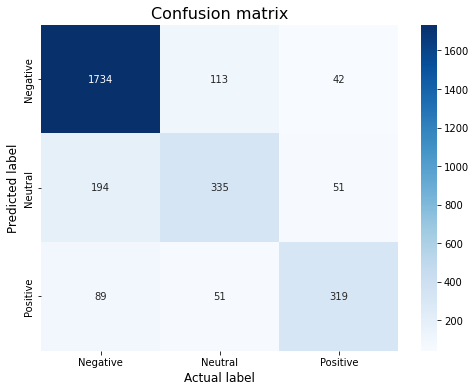

In [61]:
cr = classification_report(y_test, pred_LR)

print("Classification Report:\n----------------------\n", cr)

cm = confusion_matrix(y_test,pred_LR)


# plot confusion matrix 
plt.figure(figsize=(8,6))
sentiment_classes = ['Negative', 'Neutral', 'Positive']
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
            xticklabels=sentiment_classes,
            yticklabels=sentiment_classes)
plt.title('Confusion matrix', fontsize=16)
plt.xlabel('Actual label', fontsize=12)
plt.ylabel('Predicted label', fontsize=12)
plt.show()


LEXICON VADER

In [62]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [63]:
analyzer = SentimentIntensityAnalyzer()
scores = [analyzer.polarity_scores(tweet)['compound'] for tweet in dataset['text'].values.tolist()]
#len(scores) = len(dataset)
dataset['sentiment'] = scores

In [64]:
dataset.loc[dataset['sentiment'] == 0, 'final_sentiment'] = 0
dataset.loc[dataset['sentiment'] > 0, 'final_sentiment'] = 1
dataset.loc[dataset['sentiment'] < 0, 'final_sentiment'] = -1
dataset.head()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweetcount,text,tweet_coord,tweet_created,tweet_location,user_timezone,sentiment,final_sentiment
0,570306133677760513,0,1.0,None,None,Virgin America,None,cairdin,None,0,@VirginAmerica What @dhepburn said.,None,2015-02-24 11:35:52 -0800,None,Eastern Time (US & Canada),0.0000,0.0
1,570301130888122368,1,0.3486,None,0.0,Virgin America,None,jnardino,None,0,@VirginAmerica plus you've added commercials t...,None,2015-02-24 11:15:59 -0800,None,Pacific Time (US & Canada),0.0000,0.0
2,570301083672813571,0,0.6837,None,None,Virgin America,None,yvonnalynn,None,0,@VirginAmerica I didn't today... Must mean I n...,None,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),0.0000,0.0
3,570301031407624196,-1,1.0,Bad Flight,0.7033,Virgin America,None,jnardino,None,0,@VirginAmerica it's really aggressive to blast...,None,2015-02-24 11:15:36 -0800,None,Pacific Time (US & Canada),-0.5984,-1.0
4,570300817074462722,-1,1.0,Can't Tell,1.0,Virgin America,None,jnardino,None,0,@VirginAmerica and it's a really big bad thing...,None,2015-02-24 11:14:45 -0800,None,Pacific Time (US & Canada),-0.5829,-1.0


In [65]:
from sklearn.metrics import accuracy_score

y_act = dataset['airline_sentiment'].values
y_pred = dataset['final_sentiment'].values

accuracy_score(y_act, y_pred)

0.5465163934426229

Classification Report:
----------------------
               precision    recall  f1-score   support

          -1       0.90      0.50      0.65      9178
           0       0.40      0.42      0.41      3099
           1       0.33      0.87      0.48      2363

    accuracy                           0.55     14640
   macro avg       0.54      0.60      0.51     14640
weighted avg       0.70      0.55      0.57     14640



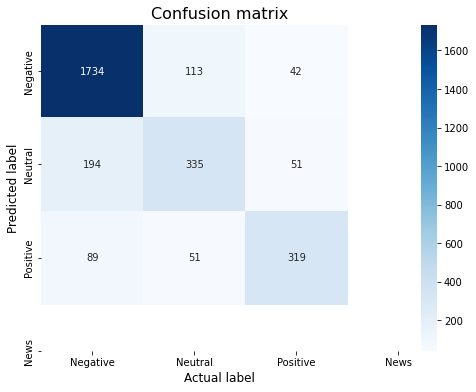

In [66]:
cr = classification_report(y_act, y_pred)

print("Classification Report:\n----------------------\n", cr)

cm = confusion_matrix(y_test,pred_LR)

plt.figure(figsize=(8,6))
sentiment_classes = ['Negative', 'Neutral', 'Positive', 'News']
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
            xticklabels=sentiment_classes,
            yticklabels=sentiment_classes)
plt.title('Confusion matrix', fontsize=16)
plt.xlabel('Actual label', fontsize=12)
plt.ylabel('Predicted label', fontsize=12)
plt.show()
